# Flight Data Recorder
<img src="media/fdr.jpg" width="300px" height="auto">

The flight data recorder is a microcontroller based system that uses a multitude of sensors to capture in-flight performance data. This includes GPS, altitude, heading, pitch, roll, angular acceleration, linear acceleration, temperature, and wind speed. The sensors are sampled at 100 Hz and written onto a microSD card in CSV format. The data recorder is removed after landing (or crash), and the data is retreived. In the case of a crash, the data visualizations can help piece together what went wrong, much like a real black box. Important metrics such as altitude and ground speed can simply be measured from the data. We can also apply descriptive analytics, to visualize patterns and correlations. This information can then be used by the team to help make design decisions and improve plane performance.

There are three useful notebooks: `flight_report.ipynb`, `data_analysis.ipynb`, and `demo.ipynb`. The `flight_report.ipynb` notebook is designed to quickly generate interactive flight reports from input data. Use this notebook if you just want to look at the reports. `data_analysis.ipynb` is better for understanding the code, as it is better documented and split into more digestable pieces. The last notebook, `demo.ipynb`, is more of a playground to get a feel for some useful python packages.

### Install Packages

```
conda install -c conda-forge ipympl cartopy
```

## Setting up the data input:


In [1]:
import pandas as pd
from math import pi,sqrt,sin,cos,asin,atan2,radians

## Modify sensor_files, fdr_files to match the files you would like to be processed. 
## Make sure the order of files correspond to matching tests
sensor_files = ['sensor_1.TXT', 'sensor_2.TXT', 'sensor_3.TXT','sensor_4.TXT','sensor_5.TXT','sensor_6.TXT']
fdr_files = ['fdr_1.TXT', 'fdr_2.TXT', 'fdr_3.TXT', 'fdr_4.TXT', 'fdr_5.TXT', 'fdr_6.TXT']

# Use relative path (you shouldn't need to change this)
path = 'inputData(1-5-21)/'
'''
sensor_files = ['sensor_1.TXT', 'sensor_2.TXT', 'sensor_3.TXT','sensor_4.TXT']
fdr_files = ['fdr_1.TXT', 'fdr_2.TXT', 'fdr_3.TXT', 'fdr_4.TXT']

# Use relative path (you shouldn't need to change this)
path = 'inputData(1-17-21)/'
'''

# the following specifies the order of data coming in a line of the CSV file; do not modify
# Count, System Calibration level (0-3), Linear Acceleration XYZ (m/s^2), Gyro XYZ (radians/sec), Quaternion WXYZ
sensor_header = ['count', 'sr_sys', 'sr_x_accel', 'sr_y_accel', 'sr_z_accel', 'sr_x_rps','sr_y_rps', 'sr_z_rps', 
                 'sr_qw', 'sr_qx', 'sr_qy', 'sr_qz']

# the FDR collects the same info as the sensor, plus GPS data appended on the end in NMEA GPGGA sentences
fdr_header = ['count', 'fr_sys', 'fr_x_accel', 'fr_y_accel', 'fr_z_accel', 'fr_x_rps', 'fr_y_rps', 'fr_z_rps', 'fr_qw', 
              'fr_qx', 'fr_qy', 'fr_qz', 'gps', 'UTC', 'lat', 'NS', 'long', 'EW', 'fix', 'sats', 'HDOP', 'elev', 'units1', 
              'geoid', 'units2', 'age', 'checksum']

## Parsing the input data into dataframes:

The input data comes in as text files in CSV format. We need to get the data off disk and into a data structure that is easier to read. We'll use the panadas package, which provides powerful tools for data analysis. For each flight, we'll open its corresponding files from the filepath and store the data into a dataframe. In the end we'll have a list of dataframes `df_list`.

In [2]:
### Parse input data files into dataframe ###


# df_list stores each flight test as a dataframe
df_list = []

# puts the csv into dataframes with a header
for i in range(len(sensor_files)):
    # add sensor file
    filepath = path + sensor_files[i]
    df_sr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_sr.columns = sensor_header
    # add fdr file
    filepath = path + fdr_files[i]
    df_fr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_fr.columns = fdr_header
    # merge dataframes sensor + fdr
    df_sr['count'] = df_sr['count'].astype(str)
    df_fr['count'] = df_fr['count'].astype(str)
    df = pd.merge(df_sr, df_fr, how='left',on='count')
    df_list.append(df)
    
print(len(df_list[1].columns))
df_list[1]

38


,count,sr_sys,sr_x_accel,sr_y_accel,sr_z_accel,sr_x_rps,sr_y_rps,sr_z_rps,sr_qw,sr_qx,...,EW,fix,sats,HDOP,elev,units1,geoid,units2,age,checksum
0,0,0,-1.89,-3.16,0.54,-73.62,-48.13,9.56,0.7084,0.5234,...,W,1,7,1.21,97.5,M,-34.2,M,NaN,*64
1,1,0,-2.71,-3.89,-0.86,-306.19,3.06,82.12,0.8034,0.3940,...,W,1,7,1.21,97.6,M,-34.2,M,NaN,*6B
2,2,0,-2.11,-0.67,-3.11,-622.25,-6.50,64.50,0.9068,0.0507,...,W,1,7,1.21,97.6,M,-34.2,M,NaN,*64
3,3,0,-1.60,-1.38,-3.62,-409.12,3.31,70.75,0.8079,-0.3535,...,W,1,7,1.21,97.6,M,-34.2,M,NaN,*6E
4,4,0,-1.43,-1.98,-1.81,483.94,-28.00,18.19,0.8378,-0.2496,...,W,1,7,1.21,97.6,M,-34.2,M,NaN,*65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,1524,0,-4.58,0.40,-7.54,326.06,20.87,-16.12,-0.6445,0.2266,...,W,1,7,1.22,147.2,M,-34.1,M,NaN,*51
1525,1525,0,-4.55,-2.05,-7.89,159.56,25.75,31.25,-0.6622,0.1091,...,W,1,7,1.22,147.3,M,-34.1,M,NaN,*51
1526,1526,0,-3.78,-2.52,-7.37,49.13,-3.69,8.94,-0.6334,0.0699,...,W,1,7,1.12,147.3,M,-34.1,M,NaN,*50
1527,1527,0,-4.19,-2.55,-6.71,-23.12,-45.56,-89.87,-0.6628,0.0602,...,W,1,7,1.22,147.3,M,-34.1,M,NaN,*5D


## Defining some functions:

To get anything meaningful from the data, we'll need to make some functions that clean and convert it to more usable values. Also we'll do some calculations to extract other important information.

In [3]:
### Function Definitions: ###

### Cleaning Functions: ###


## removes uncalibrated rows from dataframe
def remove_rows(df):
    #rows = df[(df['sr_sys'] == 0) | (df['fr_sys'] == 0)].index
    #drop rows if sensor calibration level is 0
    rows = df[df['sr_sys'] == 0].index
    df.drop(rows, inplace=True)

### Conversion Functions: ###


## remove unused columns from dataframe
def remove_cols(df):
    df.drop(['gps','UTC','NS', 'EW','HDOP','units1', 'geoid', 'units2', 'age', 'checksum','fix','sats'], axis='columns', inplace=True)

## converts float from degree-minute-second to degree, latitude conversion
def dd_lat(x):
    degrees = int(float(x)) // 100
    minutes = float(x) - 100*degrees
    return degrees + minutes/60

## converts float from degree-minute-second to degree, longitude conversion
def dd_lon(x):
    return -dd_lat(x)


### Calculation Functions: ###

# Input row of dataframe
# returns bearing from prev row's to row's GPS coords
# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
def get_bearing(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    bearing = atan2(x,y)
    return bearing

# input a row from dataframe
# returns the distance between prev coords to row's coords
# more precisely, it calculates the distance between two points on a sphere (ie. the earth)
# https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
def haversine(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']                                                          
    degree_to_rad = float(pi / 180.0)
    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad
    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    mi = 3956 * c
    return mi

# input a row from dataframe
# returns the speed using distance/time
def speed(row):
    millis = int(row['count']) - int(row['prev_count'])
    hours = millis / 36000
    return row['delta'] / hours

## Cleaning and processing the data:

Let's apply these functions to the dataframes!

In [4]:
### Clean data, Add some columns for calculations, Clean again ###

for i in range(len(df_list)):
    remove_rows(df_list[i])
    remove_cols(df_list[i])
    # remove all rows with NaN values
    df_list[i].dropna(inplace=True)
    # apply latitude and longitude conversions to all rows
    df_list[i]['lat'] = df_list[i]['lat'].apply(dd_lat)
    df_list[i]['long'] = df_list[i]['long'].apply(dd_lon)
    # add prev_lat, prev_long, prev_count columns
    df_list[i]['prev_lat'] = df_list[i]['lat'].shift(1)
    df_list[i]['prev_long'] = df_list[i]['long'].shift(1)
    df_list[i]['prev_count'] = df_list[i]['count'].shift(1)
    # deletes first row
    df_list[i].dropna(inplace=True)
    # add a instantaneous bearing based off prev GPS coord
    df_list[i]['bearing'] = df_list[i].apply(lambda row: get_bearing(row), axis=1)
    # delta distance
    df_list[i]['delta'] = df_list[i].apply(lambda row: haversine(row), axis=1)
    # add mph column
    df_list[i]['mph'] = df_list[i].apply(lambda row: speed(row), axis=1)
    # remove temp. columns
    df_list[i].drop(columns=['delta', 'prev_lat', 'prev_long', 'prev_count'], inplace=True)

In [5]:
print((df_list[1].columns))
df_list[1]

Index(['count', 'sr_sys', 'sr_x_accel', 'sr_y_accel', 'sr_z_accel', 'sr_x_rps',
       'sr_y_rps', 'sr_z_rps', 'sr_qw', 'sr_qx', 'sr_qy', 'sr_qz', 'fr_sys',
       'fr_x_accel', 'fr_y_accel', 'fr_z_accel', 'fr_x_rps', 'fr_y_rps',
       'fr_z_rps', 'fr_qw', 'fr_qx', 'fr_qy', 'fr_qz', 'lat', 'long', 'elev',
       'bearing', 'mph'],
      dtype='object')


,count,sr_sys,sr_x_accel,sr_y_accel,sr_z_accel,sr_x_rps,sr_y_rps,sr_z_rps,sr_qw,sr_qx,...,fr_z_rps,fr_qw,fr_qx,fr_qy,fr_qz,lat,long,elev,bearing,mph
81,81,1,-2.77,-0.60,-2.83,263.69,-121.00,197.25,0.9111,0.1100,...,2.81,-0.8066,0.0491,0.0112,0.5889,40.700575,-74.364607,98.5,-2.368987,40.496030
82,82,1,0.30,-2.34,-3.24,-4.75,-144.62,-11.13,0.9188,0.2018,...,2.81,-0.8080,0.0488,0.0120,0.5870,40.700563,-74.364623,98.5,-2.316351,42.747461
83,83,1,-2.63,-3.52,-1.07,-370.94,206.69,-82.50,0.9556,-0.0102,...,2.81,-0.8093,0.0505,0.0134,0.5850,40.700550,-74.364638,98.5,-2.435421,43.558698
84,84,1,-2.66,-4.54,-0.91,545.50,128.19,171.87,0.8969,0.0071,...,3.87,-0.8112,0.0492,0.0131,0.5826,40.700538,-74.364653,98.6,-2.368987,40.496041
183,183,1,-2.41,-3.77,-3.32,-704.44,152.75,-73.31,0.9106,-0.1180,...,-0.06,-0.8403,0.0311,0.0167,0.5410,40.699025,-74.365887,96.2,-2.588134,44.663359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1378,1,-4.91,-5.09,7.23,-24.37,-48.88,-161.31,-0.6950,-0.6945,...,0.31,-0.6809,0.0099,-0.0019,0.7323,40.684880,-74.386663,143.7,-2.153726,37.628714
1379,1379,1,-0.72,-9.70,3.30,-352.75,93.00,52.50,-0.8392,-0.4474,...,0.44,-0.6809,0.0084,-0.0007,0.7323,40.684872,-74.386682,143.7,-2.110791,40.288494
1380,1380,1,-3.24,-5.56,4.90,517.19,-20.00,147.06,-0.7515,-0.6028,...,0.06,-0.6809,0.0095,0.0001,0.7323,40.684862,-74.386698,143.7,-2.240171,40.058751
1381,1381,1,-4.60,-2.58,7.19,-264.94,-71.81,-3.19,-0.6389,-0.7423,...,-0.56,-0.6809,0.0098,-0.0006,0.7323,40.684853,-74.386715,143.7,-2.153726,37.628725


# Time for Visualization!
## Select the Flight:
Select the flight number to do data visualization on. Use `flight_report.ipynb` to generate visualizations for all flights.

In [6]:
f = 1

## Plotting the 2d flight path:
Now we can start visualizing the data. We'll start off with a 2d overhead view of the flight path. We'll use `matplotlib` and `cartopy` to project coordinates onto a 2d graph. We'll also import background tiles from Open Street Map, to give the path more context. We can also add some cool features such as a heatmap based on the speed and start/stop symbols.

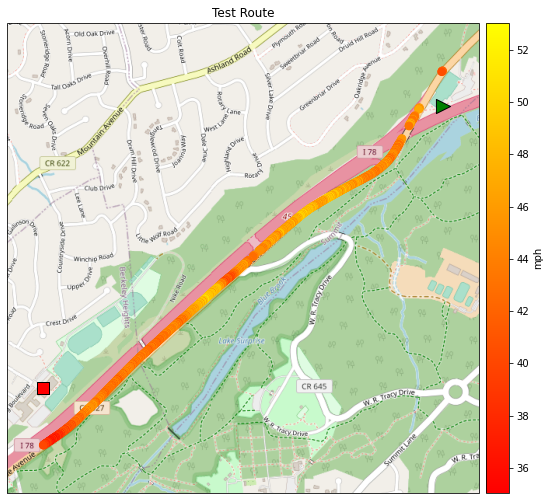

In [7]:
### Lets plot the flight path over a map ###

# https://scitools.org.uk/cartopy/docs/latest/gallery/tube_stations.html#sphx-glr-gallery-tube-stations-py
%matplotlib inline
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
# uses map tiles from Open Street Map
from cartopy.io.img_tiles import OSM
from mpl_toolkits.axes_grid1 import make_axes_locatable

# add some padding
padding_lat = 0.002
padding_lon = 0.002
# set plot window coordinates (1: bottom left 2: top right)
lat1 = df_list[f]['lat'].min() - padding_lat
lon1 = df_list[f]['long'].min() - padding_lon
lat2 = df_list[f]['lat'].max() + padding_lat
lon2 = df_list[f]['long'].max() + padding_lon

imagery = OSM()
fig = plt.figure(figsize=(9, 13))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

## Modify scale (15) to zoom in and out of the map (also increase/decreases pixelation)
ax.add_image(imagery, 15)

# plot all gps coords
scat = ax.scatter(df_list[f]['long'], df_list[f]['lat'],c=df_list[f]['mph'], cmap='autumn',s=60,alpha=1,transform=ccrs.PlateCarree())

# plot start and stop coords with special symbols
ax.scatter(df_list[f]['long'].head(1), df_list[i]['lat'].head(1),marker=">",color='green',edgecolors='black',linewidths=1,s=200,alpha=1,transform=ccrs.PlateCarree())
ax.scatter(df_list[f]['long'].tail(1), df_list[i]['lat'].tail(1),marker="s",color='red',edgecolors='black',linewidths=1,s=160,alpha=1,transform=ccrs.PlateCarree())

# add a colorbar
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(scat,cax=ax_cb,label='mph')

ax.set_title('Test Route')
plt.show()
#fig.savefig("Test_route.png")

## Plotting the 3d flight path:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

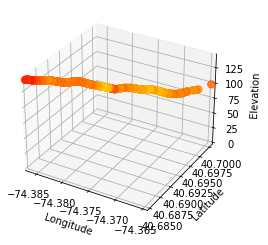

In [8]:
### Now Lets plot the datapoints in 3D ###

%matplotlib widget
#%matplotlib auto
#%matplotlib inline
#%matplotlib notebook
fig = plt.figure(figsize=(8,4)) 
ax = plt.axes(projection ='3d') 
ax.axes.set_xlim3d(left=df_list[f]['long'].min(), right=df_list[f]['long'].max()) 
ax.axes.set_ylim3d(bottom=df_list[f]['lat'].min(), top=df_list[f]['lat'].max()) 
ax.axes.set_zlim3d(bottom=0, top=df_list[f]['elev'].max()) 
ax.axes.set_xlabel('Longitude')
ax.axes.set_ylabel('Latitude')
ax.axes.set_zlabel('Elevation')

ax.scatter(df_list[f]['long'], df_list[f]['lat'], df_list[f]['elev'],s=50,c=df_list[f]['mph'],cmap='autumn',depthshade=True) 

plt.show()

In [9]:
#df_list[f].plot.scatter(x='count', y='sr_x_accel', c='mph', cmap='autumn')

## Quaternions vs Euler Angles

The absolute position of an object in 3D space is usually represented using either Euler angles or quaternions. Euler angles are probably what you're used to thinking. They consist of a set of 3 angles about the X, Y, and Z axes (yaw, pitch, and roll). However, the order in which the 3 rotations are done is important. Changing the sequence of operations can affect the final orientation of the object even if the operations are the same ([here](https://www.sjbaker.org/steve/omniv/eulers_are_evil.html) is an example). Quaternions on the other hand don't have any issues with interpretation or gimbal lock. Additionally, they don't suffer from roundoff error issues.

In the case of BNO055 IMU, Euler angles should not be trusted unless pitch and roll stay under 45 degrees (which they do not). Thus, data  from the IMU will be recorded using quaternions. 

In [10]:
### Define some Quarternion and Euler Math ###

# https://www.meccanismocomplesso.org/en/hamiltons-quaternions-and-3d-rotation-with-python/
def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def euler_to_quaternion(phi, theta, psi):
    qw = cos(phi/2) * cos(theta/2) * cos(psi/2) + sin(phi/2) * sin(theta/2) * sin(psi/2)
    qx = sin(phi/2) * cos(theta/2) * cos(psi/2) - cos(phi/2) * sin(theta/2) * sin(psi/2)
    qy = cos(phi/2) * sin(theta/2) * cos(psi/2) + sin(phi/2) * cos(theta/2) * sin(psi/2)
    qz = cos(phi/2) * cos(theta/2) * sin(psi/2) - sin(phi/2) * sin(theta/2) * cos(psi/2)
    return [qw, qx, qy, qz]

def quaternion_to_euler(w, x, y, z):
    t0 = 2 * (w * x + y * z)
    t1 = 1 - 2 * (x * x + y * y)
    X = atan2(t0, t1)
    t2 = 2 * (w * y - z * x)
    t2 = 1 if t2 > 1 else t2
    t2 = -1 if t2 < -1 else t2
    Y = asin(t2)
    t3 = 2 * (w * z + x * y)
    t4 = 1 - 2 * (y * y + z * z)
    Z = atan2(t3, t4)
    return X, Y, Z


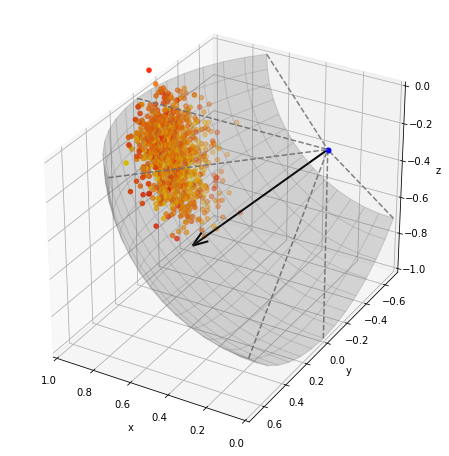

In [11]:
#%matplotlib widget
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.pyplot as plt
import numpy as np

### change parameters here
radius = 1

# define constant sqrt 2 over 2
srtot = sqrt(2)/2

fig = plt.figure(figsize=(8,8))
# add subplot with nrows, ncols, index
ax = fig.add_subplot(111, projection='3d')
# define axis scale & labels
ax.axes.set_xlim3d(left=radius, right=0) 
ax.axes.set_ylim3d(bottom=srtot*radius, top=-srtot*radius) # flip y axis for sensor
ax.axes.set_zlim3d(bottom=-radius, top=0) 
ax.axes.set_xlabel('x')
ax.axes.set_ylabel('y')
ax.axes.set_zlabel('z')

# Set equal unit aspect ratio
ax.set_box_aspect((radius, sqrt(2)*radius, radius))

# Make surface data
u = np.linspace(0, 0.5*np.pi, 15)
v = np.linspace(0.25*np.pi, 0.75*np.pi, 15)
x = radius * np.outer(np.cos(u), np.sin(v))
z = -radius * np.outer(np.sin(u), np.sin(v))
y = radius * np.outer(np.ones(np.size(u)), np.cos(v))


# set dotted line colors
lc="grey"
# horizontal 3 arrows
ax.quiver(0, 0, 0, radius, 0, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, -srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)

# vertical 3 arrows
ax.quiver(0, 0, 0, 0, 0, -radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, -srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)

# sensor
ax.quiver(0, 0, 0, srtot*radius, 0, -srtot*radius, color='black',ls='solid',lw = 2,arrow_length_ratio=0.1)


def adj_heading(row, v):
    sw = row['sr_qw']
    sx = row['sr_qx']
    sy = row['sr_qy']
    sz = row['sr_qz']
    # args: roll, pitch, yaw: 90 deg CCW for sensor reorientation
    q = euler_to_quaternion(0, 0, pi/2)
    q1 = (sw,sx,sy,sz) # <---- This raw sensor input
    q2 = q_mult(q,q1) # <---- rotate 90 deg CCW
    # now take GPS bearing and get it in quaternion
    q3 = euler_to_quaternion(0, 0, row['bearing'])
    q4 = q_mult(q3,q2)
    v = qv_mult(q4, v)
    return v

### select sample frequency
n=1

# plot transformed data
for i in range(len(df_list)):
    # start vector, no touchy
    v1 = (1,0,0)
    # account for bearing and sensor orientation
    df_list[i]['v2'] = df_list[i][::n].apply(lambda row: adj_heading(row,v1), axis=1)


vx = df_list[f]['v2'][::n].str[0].to_numpy()
vy = df_list[f]['v2'][::n].str[1].to_numpy()
vz = df_list[f]['v2'][::n].str[2].to_numpy()
ax.scatter(vx,vy,vz,c=df_list[f]['mph'][::n], cmap='autumn',depthshade=True)

# assign colors based on mph 
# https://github.com/matplotlib/matplotlib/issues/3382
C = df_list[f]['mph'][::n].to_numpy()
C = C/df_list[f]['mph'][::n].max()
cmap = plt.get_cmap()


# Plot the surface
ax.plot_surface(x, y, z, color='grey',alpha=0.2)
ax.plot_wireframe(x, y, z, color='grey',alpha=0.3, lw = 1)
# Plot a dot
ax.scatter([0], [0], [0], color="b", s=25)
# fig.savefig("test.png")
  
plt.grid(b=None)
plt.show()